In [1]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries loaded successfully!")

All libraries loaded successfully!


In [ ]:
file_path ="C:/Users/tamil/bat-mod/12_09_2015_Incremental OCV test_SP20-1.xlsx"

#This dataset (SP1_45C_IC_OCV_12_09_2015.xlsx) is sourced from:
# Zheng, F. et al. (2016). 
# Influence of different open circuit voltage tests on state of charge online 
# estimation for lithium-ion batteries. Applied Energy, 183, 513–525. 
# https://doi.org/10.1016/j.apenergy.2016.08.055

xls = pd.ExcelFile(file_path)
print(xls.sheet_names)

['Info', 'Channel_1-005_1', 'Channel_1-005_2', 'Channel_1-005_3']


In [3]:
#Separate out the sheet that has the Incremental OCV test
df = xls.parse("Channel_1-005_3")
df.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,127979,136240.345805,2015-12-10 22:50:55,1150.898365,10,17,0.0,3.851326,1.41343,1.999575,5.378778,7.102205,0.000000,0,0,0,0
1,127980,136241.345867,2015-12-10 22:50:56,1151.898428,10,17,0.0,3.851164,1.41343,1.999575,5.378778,7.102205,-0.000032,0,0,0,0
2,127981,136242.361518,2015-12-10 22:50:57,1152.914079,10,17,0.0,3.851326,1.41343,1.999575,5.378778,7.102205,0.000032,0,0,0,0
3,127982,136243.377013,2015-12-10 22:50:58,1153.929574,10,17,0.0,3.851326,1.41343,1.999575,5.378778,7.102205,0.000000,0,0,0,0
4,127983,136244.377041,2015-12-10 22:50:59,1154.929602,10,17,0.0,3.851326,1.41343,1.999575,5.378778,7.102205,0.000000,0,0,0,0


In [4]:
#Identify rest periods using a current <0.01 threshold
df_rest = df[df["Current(A)"].abs() <0.01].copy()

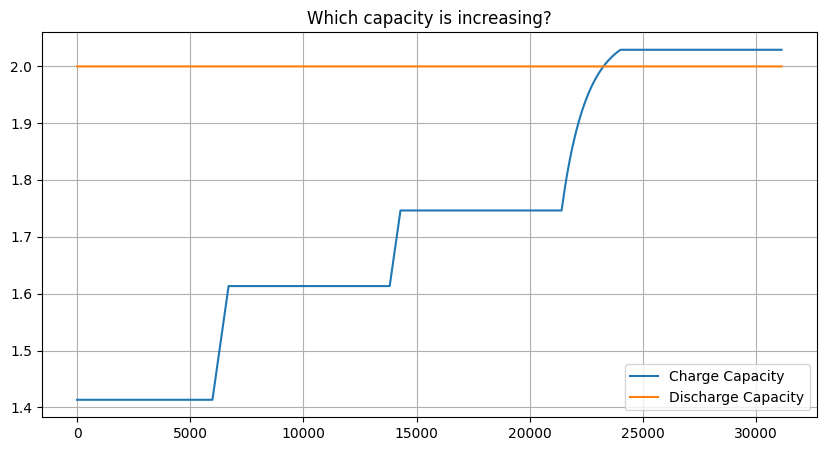

In [5]:
#Use a Visual Check to see which capacity grows with time.
#That one will serve as your SOC proxy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df["Charge_Capacity(Ah)"], label="Charge Capacity")
plt.plot(df["Discharge_Capacity(Ah)"], label="Discharge Capacity")
plt.legend()
plt.title("Which capacity is increasing?")
plt.grid(True)

In [6]:
#Since it is a charge based OCV-test, normalize the column
#Normalize capacity to SOC
df_rest["SOC"] = df_rest["Charge_Capacity(Ah)"]/df_rest["Charge_Capacity(Ah)"].max()

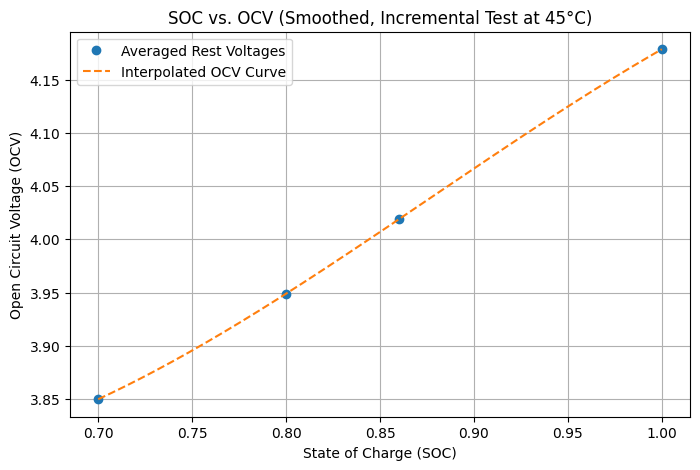

In [7]:
#Plot the SOC-OCV graph with the normalised data
# and create OCV-SOC lookup curve by the way

from scipy.interpolate import interp1d
import numpy as np

# Round SOC to 2 decimal places (adjust granularity if needed)
df_rest["SOC_rounded"] = df_rest["SOC"].round(2)

# Group by rounded SOC and average the OCV values
soc_ocv = df_rest.groupby("SOC_rounded")["Voltage(V)"].mean().reset_index()

# Build the interpolation function
soc_ocv_curve = interp1d(soc_ocv["SOC_rounded"], soc_ocv["Voltage(V)"], kind="cubic", fill_value="extrapolate")

# Create smooth SOC points for evaluation
soc_smooth = np.linspace(soc_ocv["SOC_rounded"].min(), soc_ocv["SOC_rounded"].max(), 200)
ocv_smooth = soc_ocv_curve(soc_smooth)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(soc_ocv["SOC_rounded"], soc_ocv["Voltage(V)"], 'o', label="Averaged Rest Voltages")
plt.plot(soc_smooth, ocv_smooth, label="Interpolated OCV Curve", linestyle='--')
plt.xlabel("State of Charge (SOC)")
plt.ylabel("Open Circuit Voltage (OCV)")
plt.title("SOC vs. OCV (Smoothed, Incremental Test at 45°C)")
plt.legend()
plt.grid(True)
plt.show()



In [8]:
#Try to build an ECM with the available data.
#Step 1: Build OCV-SOC Lookup curve (see above)

#Step 2: Separate out the data you'll examine
current = df["Current(A)"].values
voltage_m = df["Voltage(V)"].values

#Build the Kalman Filter
# Reinitialize filter state
timesteps = len(current)
soc_est = np.zeros(timesteps)
ocv_est = np.zeros(timesteps)
soc_est[:2500] = np.nan  # Skip these

# Parameters
# Assume a Rint model
P = 1
R0 = 0.015
Q = 1e-5
R = 1e-3
dt = 1
capacity = 1.5

# Set a realistic initial SOC at t = 2500
soc_est[2500] = 0.55  #estimate initial SOC
ocv_est[2500] = soc_ocv_curve(soc_est[2500])

# Run Kalman loop from t = 2501 onward
for t in range(2501, timesteps):
    if abs(current[t]) < 0.01:
        # No current flow → just carry forward
        soc_est[t] = soc_est[t-1]
        ocv_est[t] = soc_ocv_curve(soc_est[t])

    # Predict
    soc_pred = soc_est[t-1] - (current[t] * dt / 3600 / capacity)
    soc_pred = np.clip(soc_pred, 0, 1)
    P = P + Q

    # Estimate predicted terminal voltage
    ocv_pred = soc_ocv_curve(soc_pred)
    V_pred = ocv_pred + current[t] * R0

    # Kalman Gain
    K = P / (P + R)

    # Update SOC
    soc_est[t] = soc_pred + K * (voltage_m[t] - V_pred)
    soc_est[t] = np.clip(soc_est[t], 0, 1)
    P = (1 - K) * P

    # Store estimated OCV
    ocv_est[t] = soc_ocv_curve(soc_est[t])



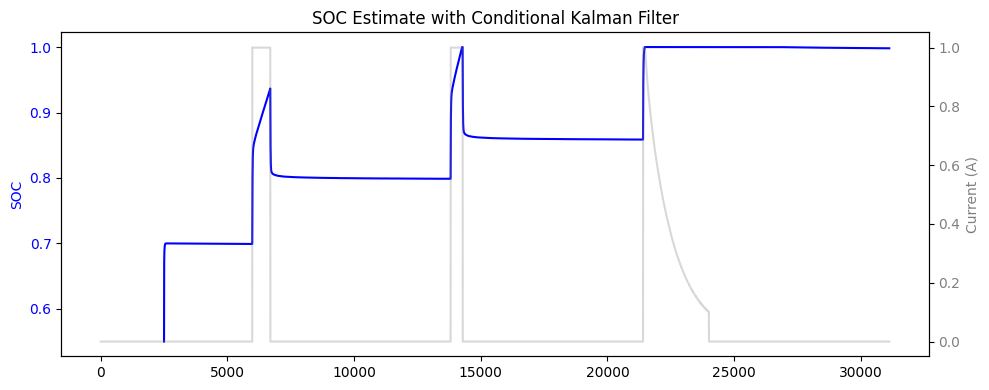

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(soc_est, label="Estimated SOC", color="blue")
ax1.set_ylabel("SOC", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(current, label="Current", color="gray", alpha=0.3)
ax2.set_ylabel("Current (A)", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

plt.title("SOC Estimate with Conditional Kalman Filter")
fig.tight_layout()
plt.show()


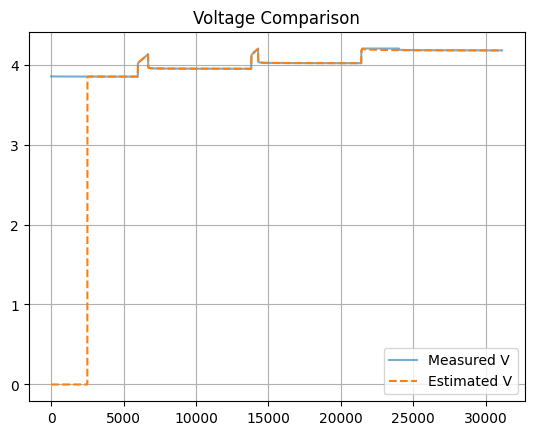

In [10]:
plt.plot(voltage_m, label="Measured V", alpha=0.6)
plt.plot(ocv_est + current * R0, label="Estimated V", linestyle="--")
plt.title("Voltage Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Re-import required libraries after code execution reset

# Extract current and voltage
current = df["Current(A)"].values
voltage_m = df["Voltage(V)"].values

# Define the Thevenin Kalman Filter
def thevenin_kalman_filter(current, voltage_m, soc_ocv_curve, capacity=1.5, start_index=2500, 
                           R0=0.015, R1=0.005, C1=2000, Q=1e-5, R=1e-3, dt=1):
    timesteps = len(current)
    soc_est = np.zeros(timesteps)
    v_rc = np.zeros(timesteps)
    ocv_est = np.zeros(timesteps)
    soc_est[:start_index] = np.nan
    v_rc[:start_index] = np.nan
    soc_est[start_index] = 0.55
    v_rc[start_index] = 0
    P = 1

    tau = R1 * C1
    alpha = np.exp(-dt / tau)

    for t in range(start_index + 1, timesteps):
        if abs(current[t]) < 0.01:
            soc_est[t] = soc_est[t-1]
            v_rc[t] = v_rc[t-1] * alpha
            ocv_est[t] = soc_ocv_curve(soc_est[t])
            continue

        soc_pred = soc_est[t-1] - (current[t] * dt / 3600 / capacity)
        soc_pred = np.clip(soc_pred, 0, 1)

        v_rc[t] = v_rc[t-1] * alpha + R1 * (1 - alpha) * current[t-1]
        ocv_pred = soc_ocv_curve(soc_pred)
        v_pred = ocv_pred + current[t] * R0 + v_rc[t]

        P = P + Q
        K = P / (P + R)
        soc_est[t] = soc_pred + K * (voltage_m[t] - v_pred)
        soc_est[t] = np.clip(soc_est[t], 0, 1)
        P = (1 - K) * P
        ocv_est[t] = soc_ocv_curve(soc_est[t])

    voltage_est = ocv_est + current * R0 + v_rc
    return soc_est, voltage_est

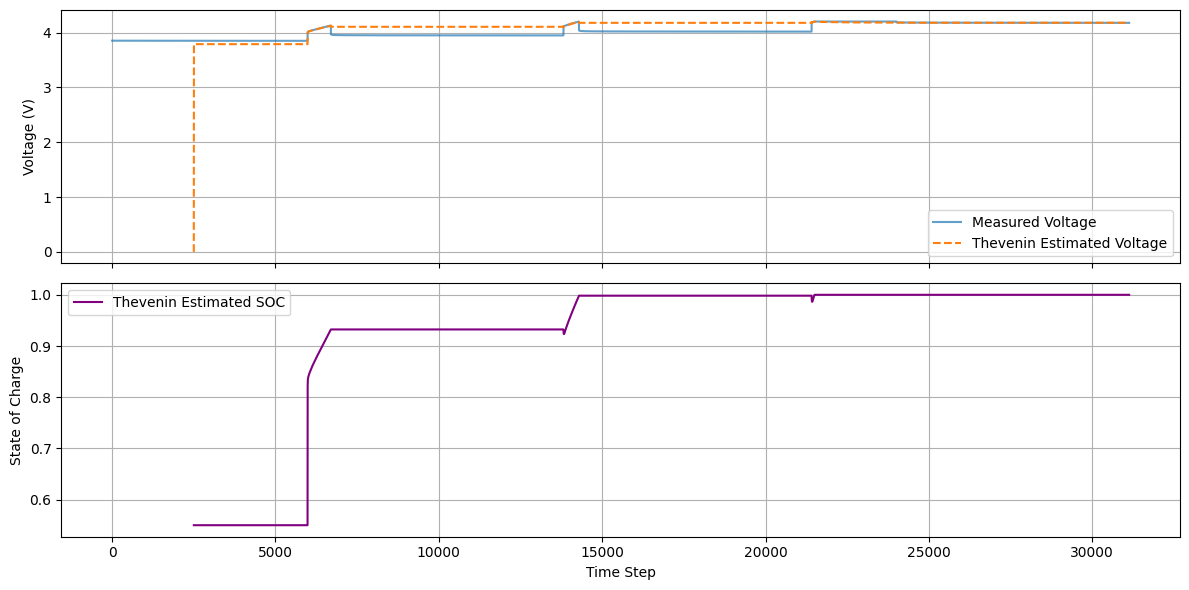

In [12]:
# Run the filter and plot
soc_est_thevenin, voltage_est_thevenin = thevenin_kalman_filter(current, voltage_m, soc_ocv_curve)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(voltage_m, label="Measured Voltage", alpha=0.7)
ax1.plot(voltage_est_thevenin, label="Thevenin Estimated Voltage", linestyle='--')
ax1.set_ylabel("Voltage (V)")
ax1.legend()
ax1.grid(True)

ax2.plot(soc_est_thevenin, label="Thevenin Estimated SOC", color="purple")
ax2.set_xlabel("Time Step")
ax2.set_ylabel("State of Charge")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()